In [2]:
library(brms)
library(tidyverse)

In [3]:
sfs_files <- list.files("../data/angsd_sfs/", full.names = TRUE)[grep(pattern = "sfs.txt", x =  list.files("../data/angsd_sfs/"))]

sfs_files <- sfs_files[map_dbl(sfs_files, ~file.size(.x)) > 0]

ref <- str_extract(sfs_files, "(v5|til11)")
ssp <- str_extract(sfs_files, "(LR|Teo)")
pop <- str_extract(sfs_files, "--(LR|Teo)--(.+)_fold") %>% str_replace("--(LR|Teo)--(.+)_fold", "\\2")
fold <- str_extract(sfs_files, "fold\\d") %>% str_remove("fold")
nucs <- str_extract(sfs_files, "fold(0|4)_(..+)_sfs.txt") %>% str_replace("fold(0|4)_(..+)_sfs.txt", "\\2")

sfs_df <- 
sfs_files %>% 
    map_df(~{
        df <- read_delim(.x, delim = " ", col_names = FALSE)
        df[, 1:(ncol(df))-1]
    }) %>% 
    mutate(ref, ssp, pop, fold, nucs) %>% 
    mutate(nuc_type = case_when(
              nucs == "AA,AT,TA,TT,GG,GC,CG,CC" ~ "SS_WW",
              nucs == "AG,AC,TG,TC" ~ "WS",
              nucs == "GA,GT,CA,CT" ~ "SW")) %>% 
    pivot_longer(cols = starts_with("X"), names_to = "allele_frequency", values_to = "frequency") %>% 
    mutate(allele_frequency = as.numeric(str_remove(allele_frequency, "X"))-1) %>% 
    group_by(ref, ssp, pop, fold, nucs) %>% 
    mutate(allele_frequency = allele_frequency/max(allele_frequency)) %>% 
    group_by(fold) %>% 
    group_split() %>% 
    reduce(
        full_join,
        by = c("ref", "ssp", "pop", "nucs", "nuc_type", "allele_frequency"), 
        suffix = c("_0", "_4")
    ) %>% 
    group_by(ref, ssp, pop, nuc_type) %>%
    arrange(ref, ssp, pop, nuc_type, allele_frequency) %>% 
    mutate(fixed_0 = last(frequency_0),
         fixed_4 = last(frequency_4),
         alpha = 1 - (fixed_4/fixed_0) * (frequency_0/frequency_4)
         ) %>% 
    drop_na()

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_logical()
)
Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_logical()
)
Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_logical()
)
Parsed with column specification:
cols(
  .default = col_double(),
  X22 = col_logical()
)
See spec(...) for 

`geom_smooth()` using formula 'y ~ x'


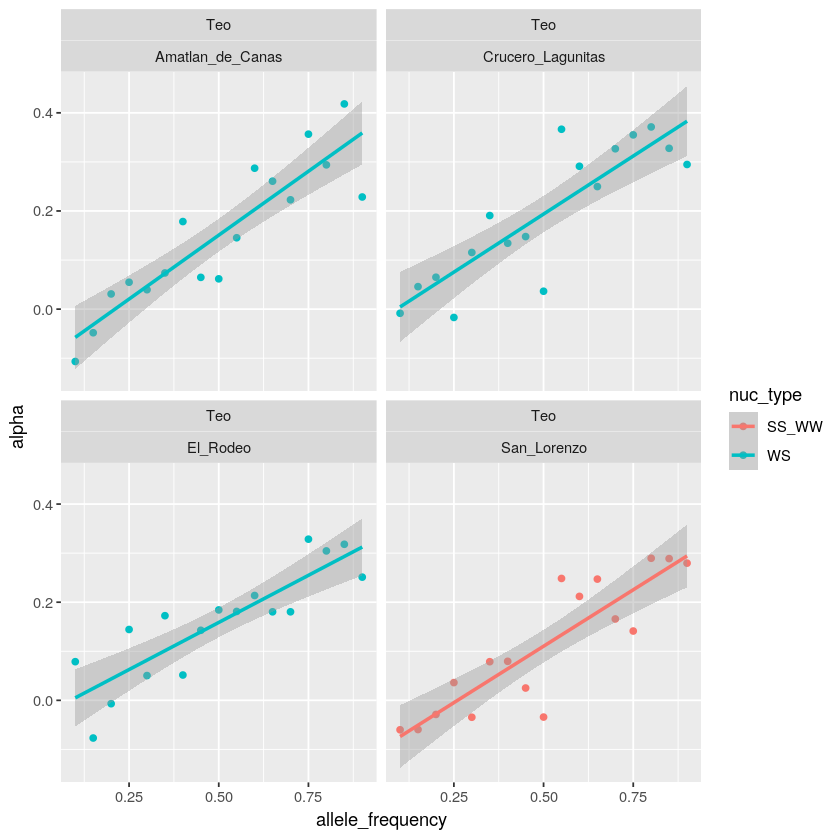

In [4]:
sfs_df %>% 
filter(between(allele_frequency, left = 0.1, right = 0.9)) %>% 
ggplot(aes(allele_frequency, alpha, colour = nuc_type)) +
geom_point() +
geom_smooth(method = "lm") +
facet_wrap(~ ssp + pop)

In [10]:
#MODELS FOR FULL DATA

prior1 <- c(
  set_prior(prior = "normal(0,0.5)", class = "b",  nlpar = "a"),
  set_prior(prior = "normal(0,0.5)", class = "b",  nlpar = "b", ub = 0),
  set_prior(prior = "normal(0,0.5)", class = "b",  nlpar = "c")
)

delt <- 0.99
treed <- 10
its <- 200
thn <- 1

mod_ssp <- brm(
  bf(
    alpha ~ a + b * exp(-c * allele_frequency), 
          a + b + c ~ 1 + (1|pop) + (1|nuc_type),
    nl = TRUE),
  data = filter(sfs_df, 
         between(allele_frequency, 0.1, 0.9)), #!!!
  family = gaussian(),
  prior = prior1, 
  iter = its,
  thin = thn,
  control = list(adapt_delta = delt, max_treedepth = treed)) %>%
  add_criterion("loo")


Compiling Stan program...
Warning message in .fun(model_code = .x1):
“C++ compiler not found on system. If absent, see
 https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started”Trying to compile a simple C file


Running /home/stittes/anaconda3/lib/R/bin/R CMD SHLIB foo.c
Error in if (nzchar(SHLIB_LIBADD)) SHLIB_LIBADD else character() : 
  argument is of length zero
Calls: <Anonymous> -> .shlib_internal
Execution halted


ERROR: Error in compileCode(f, code, language = language, verbose = verbose): Error in if (nzchar(SHLIB_LIBADD)) SHLIB_LIBADD else character() :   argument is of length zeroCalls: <Anonymous> -> .shlib_internalExecution halted


ERROR: Error in sink(type = "output"): invalid connection


In [4]:
fit1 <- brm(count ~ zAge + zBase * Trt + (1|patient), 
            data = epilepsy, family = poisson())

Compiling Stan program...
Warning message in .fun(model_code = .x1):
“C++ compiler not found on system. If absent, see
 https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started”Trying to compile a simple C file


Running /home/stittes/anaconda3/lib/R/bin/R CMD SHLIB foo.c
Error in if (nzchar(SHLIB_LIBADD)) SHLIB_LIBADD else character() : 
  argument is of length zero
Calls: <Anonymous> -> .shlib_internal
Execution halted


ERROR: Error in compileCode(f, code, language = language, verbose = verbose): Error in if (nzchar(SHLIB_LIBADD)) SHLIB_LIBADD else character() :   argument is of length zeroCalls: <Anonymous> -> .shlib_internalExecution halted


ERROR: Error in sink(type = "output"): invalid connection
